# 03_Modeling

In [1]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from sklearn.metrics import confusion_matrix, roc_auc_score
import re
from sklearn.linear_model import LogisticRegression


%matplotlib inline

### Contents:
- [1.0 Data Import](#1.0-Data-Import-and-Cleaning)
- [2.0 Model Choice](#2.0-Model-Choice)
- [3.0 Pre-processing](#3.0-Pre-processing)
    - [3.1 Clean](#Train-Summary-Statistics)
    - [3.2 Create target class](#3.2-Create-target-class)
    - [3.3 Baseline values](#3.3-Baseline-values)
- [4.0 Modelling](#4.0-Modelling)
    - [4.1 Set features and Cross train split](#4.1-Set-features-and-Cross-train-split)
    - [4.2 Posts Modelling](#4.2-Posts-Modelling)
        - [4.2.1 CountVectoriser & Logistic Regression](#4.2.1-CountVectoriser-&-Logistic-Regression)
        - [4.2.2 CountVectoriser & MultinomialNB](#4.2.2-CountVectoriser-&-MultinomialNB)
        - [4.2.3 TfidfVectorizer & Logistic Regression](#4.2.3-TfidfVectorizer-&-Logistic-Regression)
        - [4.2.4 TfidfVectorizer & MultinomialNB](#4.2.4-TfidfVectorizer-&-MultinomialNB)
    - [4.3 Combined Modelling](#4.3-Combined-Modelling)
        - [4.3.1 CountVectoriser & Logistic Regression](#4.3.1-CountVectoriser-&-Logistic-Regression)
        - [4.3.2 CountVectoriser & MultinomialNB](#4.3.2-CountVectoriser-&-MultinomialNB)
        - [4.3.3 TfidfVectorizer & Logistic Regression](#4.3.3-TfidfVectorizer-&-Logistic-Regression)
        - [4.3.4 TfidfVectorizer & MultinomialNB](#4.3.4-TfidfVectorizer-&-MultinomialNB)
- [5.0 Analysis](#5.0-Analysis)
- [6.0 Production Model](#6.0-Production-Model)
    - [6.1 Production Model Anlaysis](#6.1-Production-Model-Analysis)
    - [6.2 Feature Extraction](#6.2-Feature-Extraction)
- [7.0 Summary](#7.0-Summary)

# 1.0 Data Import

#### Get Data

In [2]:
# Retrieve data
posts_df = pd.read_csv('./data/post_eda/posts.csv', index_col = False)
comments_df = pd.read_csv('./data/post_eda/comments.csv', index_col = False)

In [3]:
# check shape is still correct
posts_df.shape, comments_df.shape

((1204, 17), (9321, 13))

In [4]:
# check columns are still correct for posts
posts_df.columns

Index(['subreddit', 'selftext', 'author_fullname', 'title', 'name',
       'upvote_ratio', 'category', 'score', 'created', 'selftext_html', 'id',
       'author', 'num_comments', 'permalink', 'url', 'created_utc', 'type'],
      dtype='object')

In [5]:
# check columns are still correct for comments
comments_df.columns

Index(['id', 'author', 'score', 'author_fullname', 'body', 'body_html',
       'permalink', 'name', 'created', 'created_utc', 'subreddit', 'link_id',
       'type'],
      dtype='object')

---

# Model Choice

The models I used were Multinomial Naive Bayes and Logisitic regression

#### Multinomial Naive Bayes

Explanation
+  Naive Bayes models estimate the conditional probability of a particular word being in a target class. The more the word occurs in the class the higher the probability it belongs to that class. It is based on the probabilities not the frequentist approach.

Weakness
+ It assumes that there is no relationships between words and they could occur in any order. Therefore it can lose so information as it doesnt take this into account.

Reason for choosing
+ This is renowned for being a very good for NLP model

+ It is possible to get the features out afterwards which will be useful for inferential statistics

+ The columns will be transformed into integer counts, so MultinomialNB works the best for this.



#### Logistic regression

Explanation
+ Another classfication algorithm

+ Uses a sigmoid function to classify anything with 0.5 probability and above to be a 1, and anything below 0.5 to be a 0


Reason for choosing
+ Coeffients of the features are interpretable which is not true about all models
+ It i s an efficient model and good for classification problems
+ Common so widely understood



#### Measurement

Accuracy
+ This is the default method Scikit uses to score its test.

AUC ROC
+ this is the false positive rate plotted against the true positive rate. The closer to 1 the better.

+ For the final model I will look at the AUC ROC curve and compare to the benchmrk

## Other methods
#### Stop words
> Stop Words are words which do not contain important significance.

Therefore I have chosen to remove stops words so they will not create noise in the models. However I will be using TFiFD which would have probably removed them anyway becuase they would have appeared in the the majority of the posts.

They can be removed by adding the hyperparameter stop_words='english' into the CountVectorizer and the TfidfVectorizer. However I have cleaned them as part of the pre-processing. This is so I can see the effect and save time during the modeling process.

#### Stemming
> Stemming is the process of reducing inflection in words to their root forms such as mapping a group of words to the same stem even if the stem itself is not a valid word in the Language.

### Below is an example

In [6]:
ps = PorterStemmer() 
  
# choose some words to be stemmed 
words = ["analytical","analytics","analysis", "analyse","science","scientist"] 
  
for w in words: 
    print(w, " : ", ps.stem(w)) 

analytical  :  analyt
analytics  :  analyt
analysis  :  analysi
analyse  :  analys
science  :  scienc
scientist  :  scientist


In demonstrations I have seen the stemming is quite crude. Therefore I will not use. I want to try and keep the word structures as much as possible.

#### Lemmatization

> Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

I will try this lemmatizing and see what the impact is.
+ My concern is that the words analytics and analytical would be reduced to the same stem but have very different meanings but it also may have a better amalgamation and provide better results for the model.



Source: [Datacamp](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)

---

# 3.0 Pre-processing

## 3.1 Clean

In [7]:
# Instantiate lemmatizer. (Same as above.)
lemmatizer = WordNetLemmatizer()

In [8]:
# Function to convert a raw text into clean data for the model

def clean_text(text):
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. Stop words could be removed as a hyperparameter later but I think it
    # will be best to do it here and save on run time
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    
    # 4.Lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lemmatized_words))


In [9]:
# Check the before
print(posts_df.iloc[1,1])

Hello all,

I am a Data Scientist at a Fortune 500 company, with a PhD in Electrical Engineering. For the last 5 years, I thought myself Python and Data Science and progressed a lot in that arena. I wanted some change after 5 years in the same company and wanted to explore options. Amazon AWS Pro Serve sounded interesting as you get to work with different companies. I did not want to work on a deep Machine Learning Problem on my cubicle (after corona, for now home desk :) ). I was excited about meeting new people and potentially solving data problems for different industries.

Am I making a right choice? Is Pro-serve considered to be same with, say "Applied scientist" role in AWS (asking in regards to: 1) career growth, 2) reputation and 3) financial) ? Is meeting new people and potentially gaining more exposure to different industries in Pro-serve a naive way of thinking? As we all know customer's behaviors can vary.

All in all I thought, exposing myself to different people and indus

In [10]:
print(posts_df.iloc[35,1])

i'm a full-time data "scientist" and my work is basically split between SWE/Data Engineering and business analytics with some modelling thrown in. most data scientists don't do research and don't follow the scientific method. i know the job title today is basically a misnomer, but what were people thinking when they thought this kind of work resembled "science"? what did OG data scientists do that made their work scientific?


In [11]:
posts_df['selftext'] = [clean_text(words) for words in posts_df['selftext']]

In [12]:
# check after 
print(posts_df.iloc[1,1])

hello data scientist fortune company phd electrical engineering last year thought python data science progressed lot arena wanted change year company wanted explore option amazon aws pro serve sounded interesting get work different company want work deep machine learning problem cubicle corona home desk excited meeting new people potentially solving data problem different industry making right choice pro serve considered say applied scientist role aws asking regard career growth reputation financial meeting new people potentially gaining exposure different industry pro serve naive way thinking know customer behavior vary thought exposing different people industry future help even become independent consultant yes whereas applied scientist need deeply involved creating aws tool scratch v using aws pro serve role experience aws pro serve data scientist role please chime thanks advance edit also want mention bad work life balance rumor aws reason assumed aws pro serve may different hopefu

In [13]:
# check after 
print(posts_df.iloc[35,1])

full time data scientist work basically split swe data engineering business analytics modelling thrown data scientist research follow scientific method know job title today basically misnomer people thinking thought kind work resembled science og data scientist made work scientific


---

## 3.2 Create target class

In [14]:
posts_df['target'] = [1 if x == 'datascience' else 0 for x in posts_df['subreddit']]

In [15]:
comments_df['target'] = [1 if x == 'datascience' else 0 for x in comments_df['subreddit']]

In [16]:
posts_df['target'].value_counts()

0    643
1    561
Name: target, dtype: int64

In [17]:
comments_df['target'].value_counts()

1    6942
0    2379
Name: target, dtype: int64

## 3.3 Baseline values

In [18]:
posts_df['target'].value_counts(normalize=True)

0    0.534053
1    0.465947
Name: target, dtype: float64

###  Observations
Therefore if I said everything was in the analytics class then I would be correct 53% of the time.

In [19]:
posts_df['target'].value_counts()

0    643
1    561
Name: target, dtype: int64

In [20]:
comments_df['target'].value_counts()

1    6942
0    2379
Name: target, dtype: int64

In [21]:
# Create combined baseline score
total_value = len(posts_df) + len(comments_df)
total_1 = posts_df['target'].value_counts()[1] + comments_df['target'].value_counts()[1]
total_0 = posts_df['target'].value_counts()[0] + comments_df['target'].value_counts()[0]

In [22]:
total_1/total_value , total_0/total_value

(0.7128741092636579, 0.28712589073634204)

###  Observations

Combined: If I said everything was in the Datascience class then I would be correct 71% of the time.

It also hightlights I will need to stratify the data as there is a class inbalance, especially for the combined data.


---

In [23]:
# Save processed data
posts_df.to_csv('./data/processed_posts/clean_posts.csv', index = False)

---

# 4.0 Modelling

## 4.1 Set features and Cross train split


In [24]:
X = posts_df['selftext'].tolist()
y = posts_df['target']

In [25]:
# cross train split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [27]:
len(X_train), len(X_test), len(y_train), len(y_test)

(903, 301, 903, 301)

## 4.2 Posts Modelling

###  4.2.1 CountVectoriser & Logistic Regression

In [28]:
# cvec = CountVectorizer()

In [29]:
# cvec.fit(X_train)

In [30]:
# Create models

# try logistic regression

In [31]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [32]:
%%time
pipe_params = {
    'cvec__max_features': [2000,3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.85, .9],
    'cvec__ngram_range': [(1,1),(1,2), (2,3)],
    'cvec__stop_words':["english"],
    'lr__C': [1,0.1,0.01],
    'lr__max_iter': [1000]
}
gs_cv = GridSearchCV(pipe1, param_grid=pipe_params)
gs_cv.fit(X_train, y_train)
print(gs_cv.best_score_)

0.8361080417434008
CPU times: user 46.5 s, sys: 117 ms, total: 46.6 s
Wall time: 46.7 s


In [33]:
gs_cv.score(X_train, y_train)

0.9689922480620154

In [34]:
gs_cv.score(X_test, y_test)

0.8272425249169435

In [35]:
gs_cv.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 3500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'lr__C': 0.1,
 'lr__max_iter': 1000}

---

###  4.2.2 CountVectorizer & MultinomialNB

In [36]:
pipe_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [37]:
pipe_params_mnb = {
    'cvec__max_features': [1000,2000,3500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.85, .9],
    'cvec__ngram_range': [(1,1),(1,2), (2,3)],
    'cvec__stop_words':["english"],
    'mnb__alpha': [0.01,0.5,1.0],
}

In [38]:
%%time
gs_mnb = GridSearchCV(pipe_mnb, param_grid=pipe_params_mnb)
gs_mnb.fit(X_train, y_train)
print(gs_mnb.best_score_)

0.8294597912829957
CPU times: user 1min 2s, sys: 132 ms, total: 1min 2s
Wall time: 1min 2s


In [39]:
gs_mnb.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 3500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'mnb__alpha': 0.01}

In [40]:
gs_mnb.score(X_train, y_train)

0.9568106312292359

In [41]:
gs_mnb.score(X_test, y_test)

0.8471760797342193

---

###  4.2.3 TfidfVectorizer & Logistic Regression

In [42]:
## Test out TF-iDF see if its better

In [43]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [44]:
pipe_params = {
    'tvec__max_features': [1000,2000,3500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1),(1,2), (2,3)],
    'tvec__stop_words':["english"],
    'lr__C': [1,0.1,0.01],
    'lr__max_iter': [1000]
}

In [45]:
%%time

gs_tf = GridSearchCV(pipe2, param_grid=pipe_params)
gs_tf.fit(X_train, y_train)
print(gs_tf.best_score_)

0.8305524861878453
CPU times: user 1min 5s, sys: 135 ms, total: 1min 6s
Wall time: 1min 6s


In [46]:
gs_tf.score(X_train, y_train)

0.9512735326688815

In [47]:
gs_tf.score(X_test, y_test)

0.8471760797342193

---

###  4.2.4 TfidfVectorizer & MultinomialNB

In [48]:
# try mnb

In [49]:
pipe_mnb_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [50]:
pipe_params_mnb_tvec = {
    'tvec__max_features': [500,1000,2000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.85,0.9],
    'tvec__ngram_range': [(1,1), (1,2), (2,3)],
    'tvec__stop_words':["english"],
    'mnb__alpha': [0.01,0.5,1.0]
}

In [51]:
%%time
gs_mnb_tvec = GridSearchCV(pipe_mnb_tvec, param_grid=pipe_params_mnb_tvec)
gs_mnb_tvec.fit(X_train, y_train)
print(gs_mnb_tvec.best_score_)

0.8261141804788213
CPU times: user 1min 3s, sys: 133 ms, total: 1min 3s
Wall time: 1min 3s


In [52]:
gs_mnb_tvec.best_estimator_

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.85, max_features=1000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('mnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [53]:
gs_mnb_tvec.score(X_train, y_train)

0.8981173864894795

In [54]:
gs_mnb_tvec.score(X_test, y_test)

0.8239202657807309

---

## Combined Modelling


### Combine datasets

In [55]:
## Join posts and comments to see if it impoves the scores
comments_df.columns.intersection(posts_df.columns)

Index(['id', 'author', 'score', 'author_fullname', 'permalink', 'name',
       'created', 'created_utc', 'subreddit', 'type', 'target'],
      dtype='object')

In [56]:
cols_to_keep = ['selftext','author','author_fullname','score','title','id','subreddit','type','target']

In [57]:
# Get the columns back from the posts and comments dataframes
comments_df.rename(columns={'body':'selftext'}, inplace=True)

In [58]:
comments_df['title'] = ''

In [59]:
combined_df = posts_df[cols_to_keep].append(comments_df[cols_to_keep])

In [60]:
combined_df.reset_index(drop=True, inplace=True)

In [61]:
combined_df.head()

,selftext,author,author_fullname,score,title,id,subreddit,type,target
0,welcome week entering amp transitioning thread...,datascience-bot,t2_4l4cxw07,1.0,Weekly Entering &amp; Transitioning Thread | 2...,hd5t6m,datascience,post,1
1,hello data scientist fortune company phd elect...,GreenerCar,t2_1jwhofnt,94.0,Amazon AWS Pro-Serve Data Scientist is it a go...,hcxeno,datascience,post,1
2,hi friend mine msc trying figure implementatio...,takathur,t2_3b84s1v5,4.0,Help with implementation of a paper about Imba...,hd4xlb,datascience,post,1
3,planning move toronto heard salary lower tax h...,remembr_this,t2_6ltcva0l,17.0,How are data science salaries in Montreal for ...,hcyrod,datascience,post,1
4,data science student even better data science ...,JDC_NITSUj,t2_12a3u30h,1.0,Seeking information about Data Science as a Un...,hd80l2,datascience,post,1


In [62]:
combined_df.tail()

,selftext,author,author_fullname,score,title,id,subreddit,type,target
10520,I'm willing to bet that you have some type of ...,againer,t2_3tddk,1.0,,fdoh9qq,analytics,comment,0
10521,why are you comparing link clicks to sessions?...,SchruteFarmsPA,t2_8eq1x,1.0,,fdpbgo2,analytics,comment,0
10522,"I would suggest this approach, albeit a bit ho...",Derangedteddy,t2_19vluyoo,3.0,,fdoufyv,analytics,comment,0
10523,This does not really sound like a seasonality ...,SlightOcelot,t2_1sh9yqtk,1.0,,fdqguc9,analytics,comment,0
10524,Not sure if this would be too technical (altho...,Welcome2B_Here,t2_42o1yrn2,2.0,,fdnhdiv,analytics,comment,0


### Cross train split

In [63]:
X = combined_df['selftext'].tolist()
y = combined_df['target']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [65]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7893, 2632, 7893, 2632)

###  4.3.1 CountVectoriser & Logistic Regression

In [66]:
pipe_cb1 = Pipeline([
    ('cvec_cb', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [67]:
%%time
pipe_params_cb = {
    'cvec_cb__max_features': [3000, 3500],
    'cvec_cb__min_df': [4,5],
    'cvec_cb__max_df': [0.8, 0.85],
    'cvec_cb__ngram_range': [(1,1), (1,2), (2,3)],
    'cvec_cb__stop_words':["english"],
    'lr__C': [1,0.1,0.01],
    'lr__max_iter': [1000]
}
gs_cvec_cb = GridSearchCV(pipe_cb1, param_grid=pipe_params_cb)
gs_cvec_cb.fit(X_train, y_train)
print(gs_cvec_cb.best_score_)

0.8161685653993198
CPU times: user 5min 46s, sys: 1.76 s, total: 5min 48s
Wall time: 5min 48s


In [68]:
gs_cvec_cb.best_params_

{'cvec_cb__max_df': 0.8,
 'cvec_cb__max_features': 3500,
 'cvec_cb__min_df': 5,
 'cvec_cb__ngram_range': (1, 2),
 'cvec_cb__stop_words': 'english',
 'lr__C': 0.1,
 'lr__max_iter': 1000}

In [69]:
gs_cvec_cb.score(X_train, y_train)

0.8739389332319777

In [70]:
gs_cvec_cb.score(X_test, y_test)

0.8252279635258358

###  4.3.2 CountVectorizer & MultinomialNB

In [71]:
pipe_cb_mnb = Pipeline([
    ('cvec_cb', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [72]:
pipe_params_cb_mnb = {
    'cvec_cb__max_features': [3500, 4000],
    'cvec_cb__min_df': [3, 4],
    'cvec_cb__max_df': [0.85, .9],
    'cvec_cb__ngram_range': [(1,1),(1,2),(2,3)],
    'cvec_cb__stop_words':["english"],
    'mnb__alpha': [0.5,1.0,2.0],
}

In [73]:
%%time
gs_cb_mnb = GridSearchCV(pipe_cb_mnb, param_grid=pipe_params_cb_mnb)
gs_cb_mnb.fit(X_train, y_train)
print(gs_cb_mnb.best_score_)

0.8195875684583223
CPU times: user 5min 28s, sys: 1.52 s, total: 5min 30s
Wall time: 5min 30s


In [74]:
gs_cb_mnb.best_params_

{'cvec_cb__max_df': 0.85,
 'cvec_cb__max_features': 4000,
 'cvec_cb__min_df': 3,
 'cvec_cb__ngram_range': (1, 2),
 'cvec_cb__stop_words': 'english',
 'mnb__alpha': 0.5}

In [75]:
gs_cb_mnb.score(X_train, y_train)

0.855188141391106

In [76]:
gs_cb_mnb.score(X_test, y_test)

0.8328267477203647

###  4.3.3 TfidfVectorizer & Logistic Regression

In [77]:
pipe_cb2 = Pipeline([
    ('tvec_cb', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [78]:
%%time
pipe_params_tf_cb = {
    'tvec_cb__max_features': [3000, 3500],
    'tvec_cb__min_df': [4,5],
    'tvec_cb__max_df': [0.8, 0.85],
    'tvec_cb__ngram_range': [(1,1), (1,2), (2,3)],
    'tvec_cb__stop_words':["english"],
    'lr__C': [1,0.1,0.01],
    'lr__max_iter': [1000]
}
gs_tvec_cb = GridSearchCV(pipe_cb2, param_grid=pipe_params_tf_cb)
gs_tvec_cb.fit(X_train, y_train)
print(gs_tvec_cb.best_score_)

0.8193352067816582
CPU times: user 5min 38s, sys: 1.32 s, total: 5min 39s
Wall time: 5min 39s


In [79]:
gs_tvec_cb.best_params_

{'lr__C': 1,
 'lr__max_iter': 1000,
 'tvec_cb__max_df': 0.8,
 'tvec_cb__max_features': 3000,
 'tvec_cb__min_df': 4,
 'tvec_cb__ngram_range': (1, 2),
 'tvec_cb__stop_words': 'english'}

In [80]:
gs_tvec_cb.score(X_train, y_train)

0.8549347523121753

In [81]:
gs_tvec_cb.score(X_test, y_test)

0.8351063829787234

###  4.3.4 TfidfVectorizer & MultinomialNB

In [82]:
pipe_cb_mnb_tf = Pipeline([
    ('tvec_cb', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [83]:
pipe_params_cb_mnb_tf = {
    'tvec_cb__max_features': [3500, 4000],
    'tvec_cb__min_df': [3, 4],
    'tvec_cb__max_df': [0.85, .9],
    'tvec_cb__ngram_range': [(1,1),(1,2),(2,3)],
    'tvec_cb__stop_words':["english"],
    'mnb__alpha': [0.5,1.0,2.0],
}

In [84]:
%%time
gs_cb_mnb_tf = GridSearchCV(pipe_cb_mnb_tf, param_grid=pipe_params_cb_mnb_tf)
gs_cb_mnb_tf.fit(X_train, y_train)
print(gs_cb_mnb_tf.best_score_)

0.813000398930513
CPU times: user 5min 28s, sys: 1.16 s, total: 5min 30s
Wall time: 5min 30s


In [85]:
gs_cb_mnb_tf.best_params_

{'mnb__alpha': 0.5,
 'tvec_cb__max_df': 0.85,
 'tvec_cb__max_features': 4000,
 'tvec_cb__min_df': 4,
 'tvec_cb__ngram_range': (1, 2),
 'tvec_cb__stop_words': 'english'}

In [86]:
gs_cb_mnb_tf.score(X_train, y_train)

0.8421386038261751

In [87]:
gs_cb_mnb_tf.score(X_test, y_test)

0.8229483282674772

---

## 5.0 Analysis

### Model Scores

|Data|Tokeniser|Model|Train Set Score|Train Set Score|
|---|---|---|---|---|
||Baseline|0.534|
||Combined Baseline|0.712|
|Posts|CountVectorizer|LogisticRegression|0.836|0.827|
|Posts|CountVectorizer|MultinomialNB|0.829|0.847|
|Posts|TfidfVectorizer|LogisticRegression|0.831|0.847|
|Posts|TfidfVectorizer|MultinomialNB|0.826|0.823|
|Combined|CountVectorizer|LogisticRegression|0.816|0.825|
|Combined|CountVectorizer|MultinomialNB|0.820|0.832|
|Combined|TfidfVectorizer|LogisticRegression|0.819|0.835|
|Combined|TfidfVectorizer|MultinomialNB|0.813|0.823|

Scores are the mean accuracy on the given data and labels.

#### Overall

+ The scores are all very close together
+ Generally there is not much overfitting which is good

#### Posts vs Combined

+ There was more overfitting in the posts data
+ The post data alone is more accurate than the Combined data. 

+ However I have decided to pick the Combined data. This is because the combined data is more likely to generalise better over unseen data. 
+ Also there is not a large gap between the two accuracy scores it gives me some flexibilty to be subjective.
 
#### TfidfVectorizer vs CountVectorizer
 + I suspected TfidfVectorizer was going to be a better fit as it tends to favour more unique words.
 + However CountVectorizer performed well it on the modelling scores also
 
 #### Key point: 
 + I will choose TfidfVectorizer as it has the highest score and also I like that it penalises words that appear too often. It should be better at picking key words. With the two reddits similar by nature this should be important.
 
#### Logistic Regression vs Multinomial Naive Bayes
+ Logistic Regression seems to be slighlty more accurate than MultinomialNB Regression on combined count vectorizer
+ There is not much difference but I will select Logistic Regression due to the highest score on the combined data.
 
 
#### Production Model
+ Combined Data, TfidfVectorizer, Logistic Regression 

---

# 6.0 Production Model

In [88]:
predictions = gs_tvec_cb.predict(X_test)

In [89]:
gs_tvec_cb.score(X_test, y_test)

0.8351063829787234

In [90]:
# best parameters for the model
gs_cb_mnb.best_params_

{'cvec_cb__max_df': 0.85,
 'cvec_cb__max_features': 4000,
 'cvec_cb__min_df': 3,
 'cvec_cb__ngram_range': (1, 2),
 'cvec_cb__stop_words': 'english',
 'mnb__alpha': 0.5}

# 6.1 Production Model Analysis

In [91]:
# Get confusion matrix score
confusion_matrix(y_test, predictions)

array([[ 386,  370],
       [  64, 1812]])

In [92]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [93]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 386
False Positives: 370
False Negatives: 64
True Positives: 1812


In [94]:
# Create a dataframe of true values of our test set and predicted probabilities based on our model.
pred_proba = [i[1] for i in gs_cb_mnb.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
8988,0,0.770985
9138,0,0.696519
828,0,0.001737
1731,1,0.439657
9740,0,0.000888
...,...,...
8155,0,0.999934
4608,1,0.999967
704,0,0.437692
7949,1,1.000000


In [95]:
type(pred_proba)

list

In [96]:
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

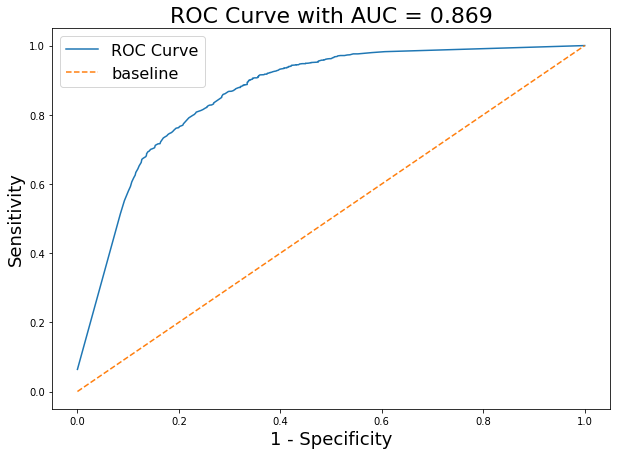

In [97]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Compare with baseline curve

In [98]:
# baseline predicts everything to be 1

In [99]:
y_test.value_counts()

1    1876
0     756
Name: target, dtype: int64

In [100]:
baseline_preds = [[0,0],[756,1876]]

In [101]:
# create a truth table
tn, fp, fn, tp = baseline_preds[0][0],baseline_preds[1][0],baseline_preds[0][1],baseline_preds[1][1]

In [102]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 0
False Positives: 756
False Negatives: 0
True Positives: 1876


In [103]:
pred_probs = [total_1/total_value]*(1876+756)

In [104]:
# Create a dataframe of true values of our test set and predicted probabilities based on our model.
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_probs})
pred_df;

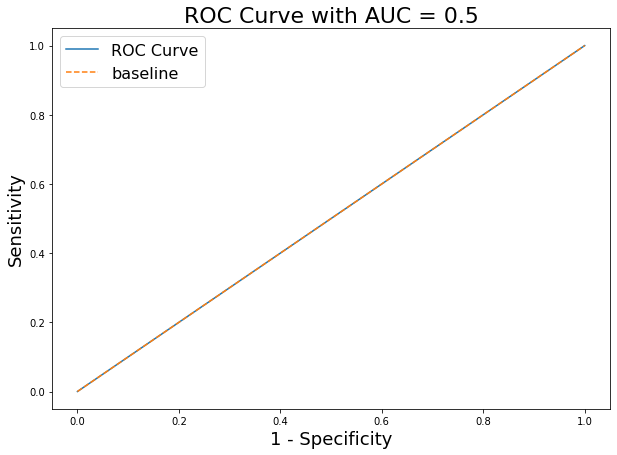

In [105]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Observation Model Vs Baseline

Our model outperforms the benchmark by:
    
    + roc auc score 0.859 vs 0.5
    + accuracy 0.826 vs 0.712

---

## 6.2 Feature Extraction

In [106]:
## Get details of best model
gs_tvec_best = gs_tvec_cb.best_estimator_
gs_tvec_best

Pipeline(memory=None,
         steps=[('tvec_cb',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=3000,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_sca

In [107]:
# pull out the information about the step the pipeline took
named_steps = gs_tvec_best.named_steps
named_steps

{'tvec_cb': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=0.8, max_features=3000,
                 min_df=4, ngram_range=(1, 2), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words='english', strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None),
 'lr': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [108]:
# check features match the models max_features
len(named_steps['tvec_cb'].get_feature_names())

3000

In [109]:
# store the features
feature_names = named_steps['tvec_cb'].get_feature_names();

In [110]:
# Transforming our x_train data using our fit cvec. Currently stored as a sparse matrix 
# And converting the result to a DataFrame.
X_train_tvec = pd.DataFrame(named_steps['tvec_cb'].transform(X_train).todense(),
                       columns=named_steps['tvec_cb'].get_feature_names())

In [111]:
# Check sparse matrix has not been transformed
X_train_tvec.shape

(7893, 3000)

In [112]:
# Get the counts or the weighs of the model
word_counts = X_train_tvec.sum(axis=0)

In [113]:
X_train_tvec.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [115]:
# Lets look through some of the categories common words
common_words = []
cw_dict = {}
for i in range(2):
    word_count = X_train_tvec.loc[y_train==i].sum(axis=0)
    cw_dict[i] = word_count
    cw = word_count.sort_values(ascending = False).head(20)
    common_words.extend(cw.index)
    
analytics_tvec_df = pd.DataFrame(cw_dict[0])
ds_tvec_df = pd.DataFrame(cw_dict[1])

#### Get Analytics key words

In [ ]:
analytics_tvec_df.reset_index(level=0, inplace=True)
analytics_tvec_df.rename(columns={0:'weight','index':"words"},inplace=True)

In [ ]:
analysis_tvec_tp15 = analytics_tvec_df.sort_values('weight', ascending=False).head(15)

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="words", y="weight", data=analysis_tvec_tp15)
ax.set_title('Shows the weight of the top 15 key words for data analytics', fontdict={'fontsize':30});


#### Get Data Science key words

In [ ]:
ds_tvec_df.reset_index(level=0, inplace=True)
ds_tvec_df.rename(columns={0:'weight','index':"words"},inplace=True)

In [ ]:
ds_tvec_tp15 = ds_tvec_df.sort_values('weight', ascending=False).head(15)

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="words", y="weight", data=ds_tvec_tp15)
ax.set_title('Shows the weight of the top 15 key words for data science', fontdict={'fontsize':30});

---

# 7.0 Summary

### Good News...

+ The model is very good at predicting which post is came from which reddit.


+ Using the combined data was good at preventing overfitting


+ The key words are similar but this reinforces the idea that the two subject matters do have overlap


### Bad news...


+ The key words might be good for the model but are to general to infer too much from.


### Next steps


+ I will do some extra supplementary analysis on the 'title' to see if there are further key words which can be extracted